# 1-1. Facial Expression Classification 구현

In [ ]:
import tensorflow as tf
import numpy as np
from skimage import io
import cv2
import os
import PIL
import tensorflow_datasets as tfds

from tensorflow.keras import datasets, layers, models
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization

import matplotlib.pyplot as plt
from google.colab import drive

import tensorflow.keras.preprocessing.image as ImageDataGenerator

In [ ]:
#google drive 연동

drive.mount('/content/gdrive/')
path = 'gdrive/MyDrive/.kaggle/train'

Mounted at /content/gdrive/


In [ ]:
# train_path = 'gdrive/MyDrive/.kaggle/train'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(32, 32),
  color_mode="grayscale")

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


In [ ]:
# test_path = 'gdrive/MyDrive/.kaggle/test'

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(32, 32),
  color_mode="grayscale")

Found 28709 files belonging to 7 classes.
Using 5741 files for validation.


In [ ]:
class_names = train_ds.class_names;
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch)
  break

(32, 32, 32, 1)
tf.Tensor([2 5 5 4 0 5 5 0 3 2 6 5 6 0 3 3 1 0 2 6 5 0 3 4 0 2 6 5 2 4 6 5], shape=(32,), dtype=int32)


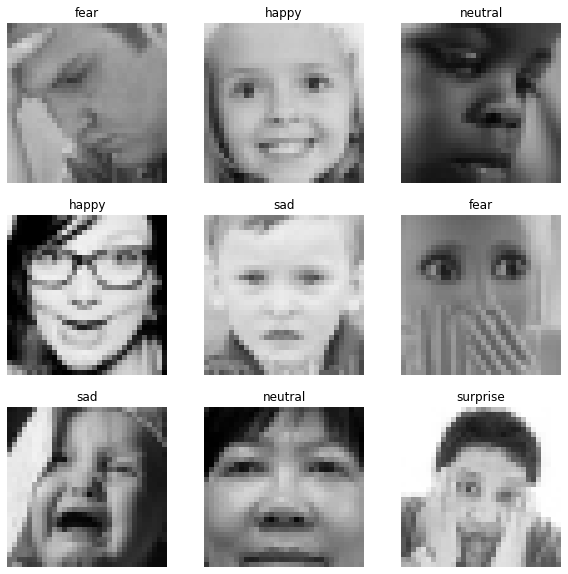

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8")[:,:,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
#data augmentation 수행

def augment(image, label):
  image = tf.image.resize_with_crop_or_pad(image, 24, 24)
  image = tf.image.random_brightness(image, max_delta=0.5)
  image = tf.clip_by_value(image, 0, 1)
  # image = tf.image.rgb_to_grayscale(images, name=None)
  image = tf.image.random_flip_left_right(image, seed=None)
  image = tf.image.random_contrast(image, 0.2, 0.5, seed=None)
  return image, label

In [ ]:
#data augmentation
augment_ds = train_ds.map(augment)

#normalization_train
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

#normalization_val
normalized_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.08063726 0.9933824
0.0 0.98897064


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#AlexNet 사용
#36(C1), 96(C2), 144(C3), 96(C4), 128(C5), 1024(FC6), 1024(FC7)
#11(F0), 5(F1), 3(F2), 3(F3), 3(F4)
#batch 128, SGD, epoch 60-20-40, learning-rate 0.01-0.001-0.0001

model = models.Sequential()
model.add(layers.InputLayer(input_shape=(32, 32, 1)))
model.add(layers.experimental.preprocessing.Rescaling(1./255))

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
# model.add(Dropout(0.5))
model.add(layers.Dense(7, activation='softmax'))
# model.add(Dropout(0.25))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 8, 64)         

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(lr=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

history = model.fit(
  train_ds,
  batch_size=128,
  validation_data=val_ds,
  epochs=50
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


Epoch 1/50
718/718 [==============================] - 5s 5ms/step - loss: 1.6371 - accuracy: 0.3541 - val_loss: 1.5440 - val_accuracy: 0.4085
Epoch 2/50
718/718 [==============================] - 4s 5ms/step - loss: 1.3898 - accuracy: 0.4660 - val_loss: 1.4224 - val_accuracy: 0.4550
Epoch 3/50
718/718 [==============================] - 4s 5ms/step - loss: 1.2513 - accuracy: 0.5229 - val_loss: 1.3952 - val_accuracy: 0.4572
Epoch 4/50
718/718 [==============================] - 4s 5ms/step - loss: 1.1436 - accuracy: 0.5679 - val_loss: 1.4616 - val_accuracy: 0.4391
Epoch 5/50
718/718 [==============================] - 4s 5ms/step - loss: 1.0420 - accuracy: 0.6048 - val_loss: 1.3657 - val_accuracy: 0.4910
Epoch 6/50
718/718 [==============================] - 3s 5ms/step - loss: 0.9315 - accuracy: 0.6488 - val_loss: 1.5582 - val_accuracy: 0.4100
Epoch 7/50
718/718 [==============================] - 3s 5ms/step - loss: 0.8220 - accuracy: 0.6914 - val_loss: 1.8236 - val_accuracy: 0.4022
Epoch 

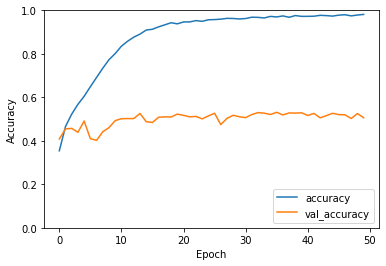

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

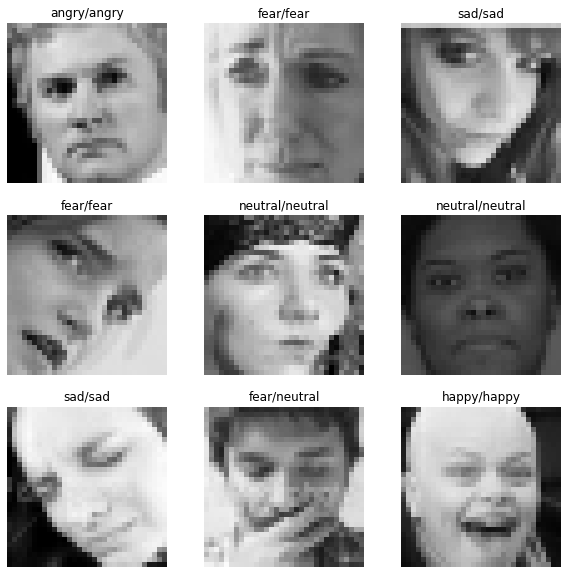

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8")[:,:,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
    a = (model.predict(images))
    plt.title(class_names[labels[i]] + '/' + class_names[tf.argmax(a[i])])
    plt.axis("off")

# 1-2. Confidence Prediction

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\n테스트 정확도:', test_acc)

predictions = model.predict(test_images)


NameError: ignored

In [ ]:
# def plot_image(i, predictions_array, true_label, img):
#   predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
#   plt.grid(False)
#   plt.xticks([])
#   plt.yticks([])

#   plt.imshow(img, cmap=plt.cm.binary)

#   predicted_label = np.argmax(predictions_array)
#   if predicted_label == true_label:
#     color = 'blue'
#   else:
#     color = 'red'

#   plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
#                                 100*np.max(predictions_array),
#                                 class_names[true_label]),
#                                 color=color)

# def plot_value_array(i, predictions_array, true_label):
#   predictions_array, true_label = predictions_array[i], true_label[i]
#   plt.grid(False)
#   plt.xticks([])
#   plt.yticks([])
#   thisplot = plt.bar(range(10), predictions_array, color="#777777")
#   plt.ylim([0, 1])
#   predicted_label = np.argmax(predictions_array)

#   thisplot[predicted_label].set_color('red')
#   thisplot[true_label].set_color('blue')

In [ ]:
# # 처음 X 개의 테스트 이미지와 예측 레이블, 진짜 레이블을 출력합니다
# # 올바른 예측은 파랑색으로 잘못된 예측은 빨강색으로 나타냅니다
# num_rows = 5
# num_cols = 3
# num_images = num_rows*num_cols
# plt.figure(figsize=(2*2*num_cols, 2*num_rows))
# for i in range(num_images):
#   plt.subplot(num_rows, 2*num_cols, 2*i+1)
#   plot_image(i, predictions, test_labels, test_images)
#   plt.subplot(num_rows, 2*num_cols, 2*i+2)
#   plot_value_array(i, predictions, test_labels)
# plt.show()

# 2. Facial Detection Pipeline 구현(by MediaPipeline)

In [ ]:
#facial detection pipeline 추가

!pip install mediapipe

import mediapipe as mp
mp_face_detection = mp.solutions.face_detection

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Read images with OpenCV.
images = {name: cv2.imread(name) for name in uploaded.keys()}
# Preview the images.
for name, image in images.items():
  print(name)   
  cv2_imshow(image)

In [ ]:
# Prepare DrawingSpec for drawing the face landmarks later.
mp_drawing = mp.solutions.drawing_utils 
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

In [ ]:
# Run MediaPipe Face Detection.
with mp_face_detection.FaceDetection(
    min_detection_confidence=0.5) as face_detection:
  for name, image in images.items():
    # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
    results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Draw face detections of each face.
    print(f'Face detections of {name}:')
    if not results.detections:
      continue
    annotated_image = image.copy()
    for detection in results.detections:
      mp_drawing.draw_detection(annotated_image, detection)
      cv2_imshow(annotated_image)